In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch

In [2]:
df = pd.read_csv('indonesian_texts_labeled_relaxed.csv')

df.head(10)

,cid,submittedVideoUrl,text,label,is_english,normalized_text,text_without_stopwords,stemmed_text,final_text,combined_text
0,7.424290e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,1.0,False,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,sayangnya orang-orang terdekat justru membuat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah
1,7.424297e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang",1.0,False,"justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang","justru orang trdekat menghancurkan mental ku, prcya siapapun, caraku mengatasi meditasi lbih tenang",justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang"
2,7.467563e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,halo ka indah sundari,0.0,False,halo ka indah sundari,ka indah sundari,ka indah sundari,ka indah sundari,halo ka indah sundari halo ka indah sundari
3,7.424316e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,justru orang terdekat malah jadi penyebabnya,0.0,False,justru orang terdekat malah jadi penyebabnya,justru orang terdekat penyebabnya,justru orang dekat sebab,justru orang dekat sebab,justru orang terdekat malah jadi penyebabnya justru orang terdekat malah jadi penyebabnya
4,7.455553e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,ka tolong aku,1.0,False,ka tolong saya,ka,ka,ka,ka tolong aku ka tolong saya
5,7.424138e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"banyak yg pengen aku ceritain, tp g bisa, g tau kenapa g bisa keluar unek² ini",0.0,False,"banyak yang ingin saya ceritain, tapi tidak bisa, tidak tahu kenapa tidak bisa keluar unek² ini","ceritain, bisa, tahu keluar unek²",ceritain bisa tahu keluar unek,ceritain bisa tahu keluar unek,"banyak yg pengen aku ceritain, tp g bisa, g tau kenapa g bisa keluar unek² ini banyak yang ingin saya ceritain, tapi tidak bisa, tidak tahu kenapa tidak bisa keluar unek² ini"
6,7.424361e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yg buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya..",1.0,False,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yang buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya..","dekat tuhan, dzikir, tahajud, shalawat baca al-qur'an.. pikiran hati jernih menemukan solusi mengatasinya..",dekat tuhan dzikir tahajud shalawat baca al-qur an pikir hati jernih temu solusi atas,dekat tuhan dzikir tahajud shalawat baca alqur an pikir hati jernih temu solusi atas,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yg buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya.. tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yang buat pikiran dan hati kita jernih sehingga kita bisa menemukan solu

In [4]:
# Load normalization dictionary from kbba.txt
normalization_dict = pd.read_csv('kbba.txt', delimiter='\t', names=['slang', 'formal'], header=None, encoding='utf-8')

slang_dict = dict(zip(normalization_dict['slang'], normalization_dict['formal']))
slang_dict

{'7an': 'tujuan',
 '@': 'di',
 'g': 'gak',
 'ka': 'kakak',
 'ababil': 'abg labil',
 'abis': 'habis',
 'acc': 'terima',
 'accor': 'accord',
 'ad': 'ada',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'adoh': 'aduh',
 'afaik': 'as far as i know',
 'aha': 'tertawa',
 'ahaha': 'haha',
 'aing': 'saya',
 'aj': 'saja',
 'aja': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ajj': 'saja',
 'ak': 'saya',
 'aka': 'dikenal juga sebagai',
 'akika': 'aku',
 'akko': 'aku',
 'akkoh': 'aku',
 'akku': 'aku',
 'akuwh': 'aku',
 'akyu': 'aku',
 'alay': 'norak',
 'alesan': 'alasan',
 'aljasa': 'asal jadi saja',
 'alow': 'halo',
 'ama': 'sama',
 'ambilin': 'ambilkan',
 'ambl': 'ambil',
 'ancur': 'hancur',
 'and': 'dan',
 'anjir': 'anjing',
 'anjrit': 'anjing',
 'ank': 'anak',
 'anter': 'antar',
 'ap': 'apa',
 'ap2': 'apa-apa',
 'apaan': 'apa',
 'apasih': 'apa sih',
 'ape': 'apa',
 'apes': 'sial',
 'apk': 'aplikasi',
 'aplot': 'unggah',
 'aplikasih': 'aplikasi',
 'app': 'aplikasi',
 'applikasi': 'aplikasi',
 'aps': 'apa

In [5]:
# Set up Indonesian stopwords and stemmer
stop_factory = StopWordRemoverFactory()
stopwords_sastrawi = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()
custom_stopwords = {
    # Pronouns & common personal references
    'aku', 'kamu', 'dia', 'kami', 'kita', 'mereka', 'saya', 'anda', 'gw', 'gue', 'lu', 'loe', 'lo', 'gua', 'kak', 'kakak',
    
    # Formal stopwords
    'yang', 'dan', 'di', 'ke', 'dari', 'pada', 'dengan', 'untuk', 'dalam', 'adalah', 'itu', 'ini',
    'juga', 'sebagai', 'oleh', 'karena', 'agar', 'atau', 'tetapi', 'namun', 'sehingga', 'supaya',
    'bagi', 'tanpa', 'bahwa', 'kalau', 'jika', 'saat', 'sebelum', 'sesudah', 'setelah', 'sementara',
    'sambil', 'sedangkan', 'seperti', 'hingga', 'meskipun', 'nya',

    # Common verbs & auxiliaries
    'adalah', 'ialah', 'merupakan', 'bukan', 'sudah', 'belum', 'akan', 'lagi', 'pernah',
    'harus', 'mau', 'dapat', 'bisa',

    # Informal abbreviations/slang
    'gak', 'ga', 'nggak', 'ngga', 'tdk', 'ngerti', 'sih', 'aja', 'kok', 'dong', 'nih', 'deh',
    'ya', 'yah', 'yee', 'loh', 'lah', 'cie', 'eh', 'btw', 'kalo', 'kalau', 'tp', 'yg', 'dr', 'pd', 'trs', 'klo'

    # Internet filler
    'wkwk', 'wkwkwk', 'haha', 'hehe', 'huhu', 'ckck', 'lol', 'lmao', 'anjay', 'banget', 'mantul',

    # Temporal
    'kemarin', 'besok', 'nanti', 'sekarang', 'tadi', 'barusan',

    # Common question words
    'apa', 'kenapa', 'mengapa', 'dimana', 'kapan', 'siapa', 'bagaimana'
}

extended_stopwords = stopwords_sastrawi.union(custom_stopwords)

def normalize_text(text):
    words = text.split()

    normalized_words = [slang_dict[word] if word in slang_dict else word for word in words]
    return " ".join(normalized_words)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in extended_stopwords])
    text = stemmer.stem(text)  # stemming in Bahasa Indonesia
    return text


In [6]:
df['text'] = df['text'].apply(normalize_text)

df.head(10)

,cid,submittedVideoUrl,text,label,is_english,normalized_text,text_without_stopwords,stemmed_text,final_text,combined_text
0,7.424290e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,1.0,False,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,sayangnya orang-orang terdekat justru membuat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah
1,7.424297e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"justru bahkan orang trdekat yang menghancurkan mental ku, aku tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang",1.0,False,"justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang","justru orang trdekat menghancurkan mental ku, prcya siapapun, caraku mengatasi meditasi lbih tenang",justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang"
2,7.467563e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,halo kakak indah sundari,0.0,False,halo ka indah sundari,ka indah sundari,ka indah sundari,ka indah sundari,halo ka indah sundari halo ka indah sundari
3,7.424316e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,justru orang terdekat bahkan jadi penyebabnya,0.0,False,justru orang terdekat malah jadi penyebabnya,justru orang terdekat penyebabnya,justru orang dekat sebab,justru orang dekat sebab,justru orang terdekat malah jadi penyebabnya justru orang terdekat malah jadi penyebabnya
4,7.455553e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,kakak tolong aku,1.0,False,ka tolong saya,ka,ka,ka,ka tolong aku ka tolong saya
5,7.424138e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"banyak yang ingin aku ceritain, tapi gak bisa, gak tahu kenapa gak bisa keluar unek² ini",0.0,False,"banyak yang ingin saya ceritain, tapi tidak bisa, tidak tahu kenapa tidak bisa keluar unek² ini","ceritain, bisa, tahu keluar unek²",ceritain bisa tahu keluar unek,ceritain bisa tahu keluar unek,"banyak yg pengen aku ceritain, tp g bisa, g tau kenapa g bisa keluar unek² ini banyak yang ingin saya ceritain, tapi tidak bisa, tidak tahu kenapa tidak bisa keluar unek² ini"
6,7.424361e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"tapi iya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yang buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya..",1.0,False,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yang buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya..","dekat tuhan, dzikir, tahajud, shalawat baca al-qur'an.. pikiran hati jernih menemukan solusi mengatasinya..",dekat tuhan dzikir tahajud shalawat baca al-qur an pikir hati jernih temu solusi atas,dekat tuhan dzikir tahajud shalawat baca alqur an pikir hati jernih temu solusi atas,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yg buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya.. tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yang buat pikiran dan hati kita jernih seh

In [7]:
text_column = 'text'
label_column = 'label'

df = df[[text_column, label_column]].dropna()
df[text_column] = df[text_column].astype(str).apply(preprocess_text)

if df[label_column].dtype != int:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

df.head(10)

,text,label
0,sayang orangorang dekat justru buat mental sakit lelah,1
1,justru bahkan orang trdekat hancur mental ku prcya siapa cara atas semua meditasi lbih tenang,1
2,halo indah sundari,0
3,justru orang dekat bahkan jadi sebab,0
4,,1
5,banyak ceritain tahu keluar unek,0
6,iya memang dekat tuhan banyak dzikir tahajud shalawat baca alquran buat pikir hati jernih temu solusi atas,1
7,suka sedih bilang masalah mental jauh tuhann,1
8,masa temu bahagia asing diri ramai benar kata sayyidina ali,1
9,orang ibu rumah tangga lama sekali selalu bicara sndrian sndri bicara sedang obrol padahal sedang sndrian belum rasa biasa,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335 entries, 0 to 13334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13335 non-null  object
 1   label   13335 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 208.5+ KB


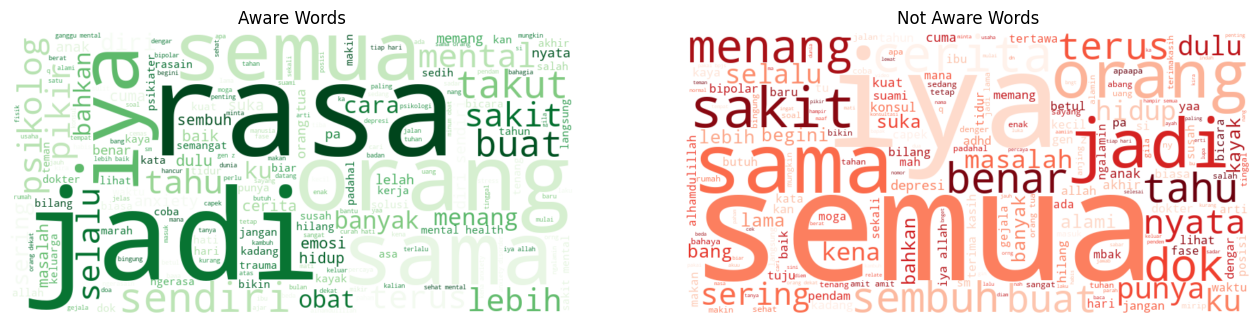

In [9]:
positive_texts = df[df[label_column] == 1][text_column]
negative_texts = df[df[label_column] == 0][text_column]

positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(' '.join(positive_texts))
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(negative_texts))

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Aware Words')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Not Aware Words')
plt.show()

In [10]:
vocab_size = 10000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

word_index = tokenizer.word_index

In [11]:
embedding_index = {}
embedding_dim = 300  # FastText Indo = 300 dimensions

with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  # Skip the header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df[label_column], test_size=0.2, random_state=42)

In [13]:
def build_model(hp):
    model = Sequential()

    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=hp.Choice('embedding_trainable', [True, False])
    ))

    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    )))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='sentiment_tuning'
)

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
tuner.search(X_train, y_train,
             epochs=5,
             batch_size=32,
             validation_split=0.2,
             verbose=1)

Trial 10 Complete [00h 04m 00s]
val_accuracy: 0.9397844672203064

Best val_accuracy So Far: 0.9402530491352081
Total elapsed time: 00h 36m 52s


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_model.summary()

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 64)        │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,112,193 (11.87 MB)

 Trainable params: 3,112,193 (11.87 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    validation_data=None,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9646 - loss: 0.1141 - val_accuracy: 0.9264 - val_loss: 0.2558
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9780 - loss: 0.0903 - val_accuracy: 0.9306 - val_loss: 0.2786
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9874 - loss: 0.0546 - val_accuracy: 0.9189 - val_loss: 0.3921
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9927 - loss: 0.0335 - val_accuracy: 0.9171 - val_loss: 0.4847


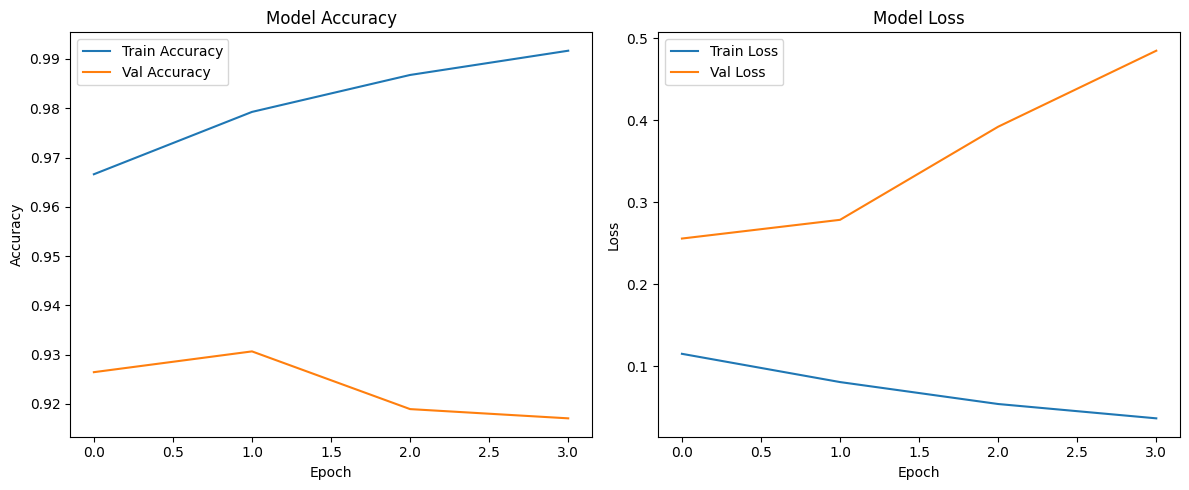

In [19]:
# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

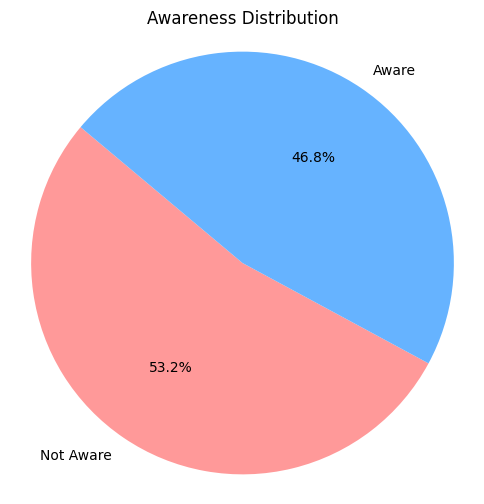

In [20]:
# Label mapping (optional, only if using integers)
label_names = {0: 'Not Aware', 1: 'Aware'}

# Count label frequencies
label_counts = df[label_column].value_counts().sort_index()
labels = [label_names[i] for i in label_counts.index]
sizes = label_counts.values
colors = ['#ff9999','#66b3ff']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Awareness Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


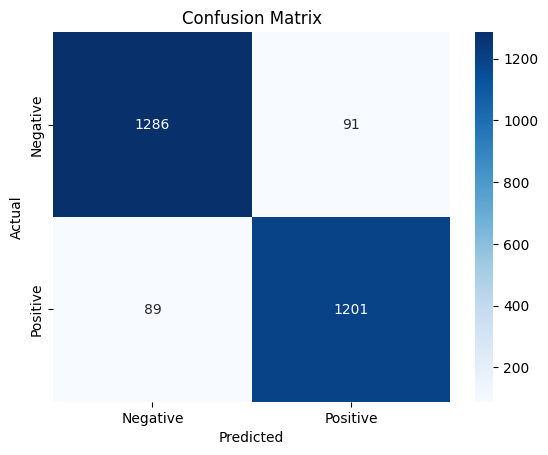


Classification Report:

              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      1377
    Positive       0.93      0.93      0.93      1290

    accuracy                           0.93      2667
   macro avg       0.93      0.93      0.93      2667
weighted avg       0.93      0.93      0.93      2667

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9292 - loss: 0.2369

Test Results:

Loss: 0.2327636033296585
Accuracy: 0.9325084090232849


In [21]:
# Predictions
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

test_results = best_model.evaluate(X_test, y_test)
print("\nTest Results:\n")
print(f"Loss: {test_results[0]}")
print(f"Accuracy: {test_results[1]}")